In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import corner

from pesummary.core.plots.bounded_1d_kde import bounded_1d_kde, TransformBoundedKDE
from pesummary.gw.plots.bounds import default_bounds
from scipy import stats

import tensorflow as tf
import tensorflow_probability as tfp
import gpflow
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from uncertainties import unumpy

from gp4gw.density.bounded_model import BoundedDensityModel
from gp4gw.density.data_preparation import *
from gp4gw.density.training_tools import *

# import scipy.integrate as integrate
from scipy import interpolate

In [2]:
%matplotlib inline

In [3]:
np.random.seed(103543)

## Plotting Code (could make a plotting utils module but the plots are very tuned for this example)

In [4]:
def get_fill_positions(lower_contours, upper_contours):
    i = 0 # corresponds to upper bound

    ar_len_upper = 0    
    for j in range(len(lower_contours.collections[i].get_paths())):
        ar_len_upper += len(lower_contours.collections[i].get_paths()[j])

    xx_upper = np.zeros(ar_len_upper)
    yy_upper = np.zeros(ar_len_upper)
    disc = []
    start = 0

    for j in range(len(lower_contours.collections[i].get_paths())):
        pp = lower_contours.collections[i].get_paths()[j]
        vv = pp.vertices
        disc.append(start + vv.shape[0] + j)
        xx_upper[start : start + vv.shape[0]] = vv[:, 0]
        yy_upper[start : start + vv.shape[0]] = vv[:, 1]
        start = start + vv.shape[0]

    for point in disc: 
        xx_upper = np.insert(xx_upper, point, np.nan)
        yy_upper = np.insert(yy_upper, point, np.nan)

    i = 1 # corresponds to lower bound
    ar_len_lower = 0    
    for j in range(len(lower_contours.collections[i].get_paths())):
        ar_len_lower += len(lower_contours.collections[i].get_paths()[j])

    xx_lower = np.zeros(ar_len_lower)
    yy_lower = np.zeros(ar_len_lower)
    disc = []
    start = 0


    for j in range(len(lower_contours.collections[i].get_paths())):
        pp = lower_contours.collections[i].get_paths()[j]
        vv = pp.vertices
        disc.append(start + vv.shape[0] + j)
        xx_lower[start : start + vv.shape[0]] = vv[:, 0]
        yy_lower[start : start + vv.shape[0]] = vv[:, 1]
        start = start + vv.shape[0]

    for point in disc: 
        xx_lower = np.insert(xx_lower, point, np.nan)
        yy_lower = np.insert(yy_lower, point, np.nan)

    # don't need loop here as contour at 90% is one array,
    # this is because there are no islands

    p = upper_contours.collections[1].get_paths()[0]
    v = p.vertices
    xxx_lower = v[:, 0]
    yyy_lower = v[:, 1]

    p = upper_contours.collections[0].get_paths()[0]
    v = p.vertices
    xxx_upper = v[:, 0]
    yyy_upper = v[:, 1]

    # need to interpolate the surface so that we can evaluate all contours at the same 
    # points, we can then do fill between at these points
    tck_lower, u_lower = interpolate.splprep([xxx_lower,
                                              yyy_lower], s=0)
    unew = np.linspace(0,
                       1.01,
                       len(xx_lower))
    out_lower = interpolate.splev(unew,
                            tck_lower)
    
    tck_upper, u_lower = interpolate.splprep([xxx_upper,
                                              yyy_upper], s=0)
    unew = np.linspace(0,
                       1.01,
                       len(xx_upper))

    out_upper = interpolate.splev(unew,
                            tck_upper                             
                                 )
    interp_lower_x= out_lower[0]
    interp_lower_y= out_lower[1]
    
    interp_upper_x = out_upper[0][::5]
    interp_upper_y = out_upper[1][::5]
    
    return xx_lower, xx_upper, yy_lower, yy_upper, interp_lower_x, interp_lower_y, interp_upper_x, interp_upper_y


def make_zoom_insets(samples,
                     xx_lower,
                     interp_lower_x,
                     yy_lower,
                     interp_lower_y,
                     xx_upper,
                     interp_upper_x,
                     yy_upper,
                     interp_upper_y, 
                     new_bin_array
                    ):
    # This is very messy, should use a named tuple to simplify number of arguments !
    ax2 = plt.axes([0.18, 0.4, 0.12, 0.12])
    ax2.scatter(samples['ra'], samples['dec'], color="k", s = 0.5, marker="o", alpha = 0.5)

    ax2.fill(np.append(xx_lower, interp_lower_x[::-1]),
             np.append(yy_lower, interp_lower_y[::-1]), color = 'darkorange', alpha = 0.5)

    ax2.fill(np.append(xx_upper[::5], interp_upper_x[::-1]),
             np.append(yy_upper[::5], interp_upper_y[::-1]), color = 'darkorange', alpha = 0.5
                   )

    ax2.contour(
        z.T,
        t_contours,
        extent=[new_bin_array[0, :].min(), new_bin_array[0, :].max(), new_bin_array[1, :].min(), new_bin_array[1, :].max()],
        colors="darkorange",
        alpha = 1,
        linewidths=1,
    )

    ax2.set_xlim(0.8, 1.1)
    ax2.set_ylim(-1.1, -0.8)

    ax2.set_yticks([])
    ax2.set_xticks([])

    ax3 = plt.axes([0.34, 0.4, 0.12, 0.12])
    ax3.scatter(samples['ra'], samples['dec'], color="k", s = 0.5, marker="o", alpha = 0.5)

    ax3.fill(np.append(xx_lower, interp_lower_x[::-1]),
             np.append(yy_lower, interp_lower_y[::-1]), color = 'darkorange', alpha = 0.5)

    ax3.fill(np.append(xx_upper[::5], interp_upper_x[::-1]),
             np.append(yy_upper[::5], interp_upper_y[::-1]), color = 'darkorange', alpha = 0.5
                   )
    ax3.contour(
        z.T,
        t_contours,
        extent=[new_bin_array[0, :].min(), new_bin_array[0, :].max(), new_bin_array[1, :].min(), new_bin_array[1, :].max()],
        colors="darkorange",
        alpha = 1,
        linewidths=1,
    )

    ax3.set_xlim(1.45, 2.1)
    ax3.set_ylim(-1.33, -1.1)

    ax3.set_yticks([])
    ax3.set_xticks([])


    ax4 = plt.axes([0.5, 0.4, 0.12, 0.12])
    ax4.scatter(samples['ra'], samples['dec'], color="k", s = 0.5, marker="o", alpha = 0.5)

    ax4.fill(np.append(xx_lower, interp_lower_x[::-1]),
             np.append(yy_lower, interp_lower_y[::-1]), color = 'darkorange', alpha = 0.5)

    ax4.fill(np.append(xx_upper[::5], interp_upper_x[::-1]),
             np.append(yy_upper[::5], interp_upper_y[::-1]), color = 'darkorange', alpha = 0.5
                   )

    ax4.contour(
        z.T,
        t_contours,
        extent=[new_bin_array[0, :].min(), new_bin_array[0, :].max(), new_bin_array[1, :].min(), new_bin_array[1, :].max()],
        colors="darkorange",
        alpha = 1,
        linewidths=1,
    )

    ax4.set_xlim(2.4, 2.7)
    ax4.set_ylim(-1.2, -0.9)

    ax4.set_yticks([])
    ax4.set_xticks([])
    
def plot_1d_histograms_with_GP(axes, samples, bins, ra_mean, dec_mean, ra_lower, ra_upper, dec_lower, dec_upper):
    
    axes[0, 0].hist(
    samples["ra"],
    density=True,
    histtype="step",
    bins=bin_plot[0][::6],
    linewidth=2,
    label="PE samples",
    color='k',
    )


    axes[1, 1].hist(
        samples["dec"],
        density=True,
        histtype="step",
        bins=bin_plot[1][::6],
        orientation="horizontal",
        linewidth=2,
        color='k',
    )

    axes[0, 0].plot(
        centroid_calc(bins[0]),
        ra_mean,
        color='darkorange',
        label=r"GP $\mu(\vec{x})$, $2\sigma(\vec{x})$",
)
    axes[1, 1].plot(dec_mean, centroid_calc(bins[1]), color='darkorange')


    axes[0, 0].fill_between(
        centroid_calc(bins[0]),
        ra_upper,
        ra_lower,
        color='darkorange',
        alpha=0.2,
    )

    axes[1, 1].fill_betweenx(
        centroid_calc(bins[1]),
        dec_upper,
        dec_lower,
        color='darkorange',
        alpha=0.2,
    )


    
def plot_1d_credible_intervals(axes, f_ra, f_dec, summary_ra, summary_dec):

    axes[0, 0].axvline(
        summary_ra.median - summary_ra.minus, ls="--", color='k'
    )
    axes[0, 0].axvline(
        summary_ra.median + summary_ra.plus, ls="--", color='k'
    )

    axes[0, 0].axvline(
        f_ra(0.16), ls="--", color='orange'
    )
    axes[0, 0].axvline(
        f_ra(0.84), ls="--", color='orange'
    )


    axes[1, 1].axhline(
        summary_dec.median - summary_dec.minus, ls="--", color='k'
    )

    axes[1, 1].axhline(
        summary_dec.median + summary_dec.plus, ls="--", color='k'
    )

    axes[1, 1].axhline(
        f_dec(0.16), ls="--", color='orange'
    )
    axes[1, 1].axhline(
        f_dec(0.84), ls="--", color='orange'
    )
    
    
def get_contour_bounds(axes, t_contours, z_low, z_high):
    # get contour upper and lower
    upper_contours = axes[1, 0].contour(
        z_high.T,
        t_contours,
        extent=[new_bin_array[0, :].min(), new_bin_array[0, :].max(), new_bin_array[1, :].min(), new_bin_array[1, :].max()],
        colors="darkorange",
        linewidths=0,
        alpha = 0.2,
    )

    lower_contours = axes[1, 0].contour(
        z_low.T,
        t_contours,
        extent=[new_bin_array[0, :].min(), new_bin_array[0, :].max(), new_bin_array[1, :].min(), new_bin_array[1, :].max()],
        colors="darkorange",
        linewidths=0,
        alpha = 0.2,
    )
    return lower_contours, upper_contours

def make_central_fill_plot(xx_lower, xx_upper, yy_lower, yy_upper, interp_lower_x, interp_lower_y, interp_upper_x, interp_upper_y):

    axes[1, 0].fill(np.append(xx_lower, interp_lower_x[::-1]),
             np.append(yy_lower,interp_lower_y[::-1]), color = 'darkorange', alpha = 0.5)

    axes[1, 0].fill(np.append(xx_upper[::5], interp_upper_x[::-1]),
             np.append(yy_upper[::5], interp_upper_y[::-1]), color = 'darkorange', alpha = 0.5)


    axes[1, 0].contour(
        z.T,
        t_contours,
        extent=[new_bin_array[0, :].min(), new_bin_array[0, :].max(), new_bin_array[1, :].min(), new_bin_array[1, :].max()],
        colors="darkorange",
        alpha = 1,
        linewidths=1,
    )

    axes[1, 0].scatter(unscaled_data['ra'], unscaled_data['dec'], color="k", s = 1., marker="o", alpha = 0.5)
    
def plot_arrows(axes):
    axes[1, 0].arrow(1., -0.85, 0.05, 0.2, width = 0.01, head_width = 0.05, color = 'k')

    axes[1, 0].arrow(2.4, -1., -0.05, 0.35, width = 0.01, head_width = 0.05, color = 'k')
    axes[1, 0].arrow(1.75, -1.13, 0., 0.45, width = 0.01, head_width = 0.05, color = 'k')
    

def do_plot_formatting():
    for ax in fig.get_axes():
        ax.tick_params(axis="both", labelsize=12)
    plt.subplots_adjust(wspace=0, hspace=0)

    axes[0, 0].set_xticklabels([])
    axes[0, 0].set_yticklabels([])
    axes[0, 1].axis("off")

    axes[1, 0].set_xlabel("ra", fontsize=20)
    axes[1, 0].set_ylabel("dec", fontsize=20)

    axes[1, 1].set_xticklabels([])
    axes[1, 1].set_yticklabels([])


    axes[0,0].set_ylim(-0.03, 1.3)

    axes[1,1].set_xlim(-0.15, 6.7)
    

def add_legend_to_plot(axes):
    handles, labels = axes[0, 0].get_legend_handles_labels()

    order = [1, 0]

    axes[1, 0].legend(
        [handles[idx] for idx in order],
        [labels[idx] for idx in order],
        fontsize=18,
        loc="lower center",
        bbox_to_anchor=(0.23, 0.79),
    )
    

# Loading posterior samples and selecting 2 dimensions to interpolate, e.g. sky location parameters

In [5]:
data_path = "/home/virginia.demilio/GP-density-estimation/pe_samples/GW150914_downsampled_posterior_samples.dat"

In [6]:
unscaled_data = pd.read_csv(data_path).sample(frac=1)
print("Posterior samples array: ", unscaled_data.shape)

Posterior samples array:  (50000, 42)


In [7]:
param_names = ["ra", "dec"]

# Select optimal binning

We bin the data such that w have a few empty bins where the probability is zero

In [8]:
Nb = 35
bin_array = np.vstack(
    [
        np.linspace(
            unscaled_data["ra"].min() - 0.1, unscaled_data["ra"].max() + 0.1, Nb
        ),
        np.linspace(
            unscaled_data["dec"].min() - 0.1, unscaled_data["dec"].max() + 0.1, Nb
        ),
    ]
)

# Setting up histogram and scale data

The posterior (log_likelihood + log_prior) is defined over all parameters (~15D). 

We want to interpolate only over a slice (say 2D), i.e. the marginal posterior, which we can approximate as the value of bin counts in the 2D histogram.

In [9]:
counts, bins = np.histogramdd(
    np.array(unscaled_data[param_names]), density=True, bins=bin_array
)

In [10]:
x = create_2d_data_set(bins)
y = counts.flatten()

Shape of binning: (34, 2)
Histogram points: (1156, 2)


In [11]:
x_scaled, y_scaled, x_scaler, y_scaler = scale_data(x, y)

X = tf.convert_to_tensor(x_scaled, dtype=tf.float64)
Y = tf.convert_to_tensor(y_scaled.reshape(-1, 1), dtype=tf.float64)

Shape of x-data: N=1156, Q=2


In [12]:
prior_ranges = {
    "ra": tfp.distributions.Uniform(
        unscaled_data["ra"].min(), unscaled_data["ra"].max()
    ),
    "dec": tfp.distributions.Uniform(
        unscaled_data["dec"].min(), unscaled_data["dec"].max()
    ),
}

# Setup GP model
* add noise error from histogram to the GP likelihood
* define kernel

In [13]:
dens_std, dens_std_unscaled = calc_hist_errors(np.array(unscaled_data[param_names]), bin_array, y_scaler)

In [14]:
dens_std_1 = dens_std 

In [15]:
var = dens_std_1 ** 2 +  1 * 10 ** - 6  # adding some jitter to avoid Cholesky decomposition and 1/0 errors

In [16]:
Y_data = np.hstack([Y, tf.reshape(var, (-1, 1))])

In [17]:
likelihood = HeteroskedasticGaussian()

In [18]:
kernel = gpflow.kernels.RBF(lengthscales=[0.1] * len(param_names), variance=0.1)

In [19]:
model = gpflow.models.VGP(
    (X, Y_data),
    kernel=kernel,
    likelihood=likelihood,
    num_latent_gps=1,
    mean_function=gpflow.mean_functions.Constant(y_scaler.transform(np.zeros((1, 1)))),  # we set the mean GP to be zero probability dnsity
)

In [20]:
set_trainable(model.mean_function, False)

# Build GP model

In [21]:
natgrad = gpflow.optimizers.NaturalGradient(gamma=1.)
adam = tf.optimizers.Adam(lr =5 * 10**-3)

Epoch 10: LOSS (train) 19366.478601557683
Epoch 20: LOSS (train) 19115.486637603393
Epoch 30: LOSS (train) 18794.910089700254
Epoch 40: LOSS (train) 18295.984942704705
Epoch 50: LOSS (train) 17636.729697556962
Epoch 60: LOSS (train) 16820.776348802618
Epoch 70: LOSS (train) 15879.06466398219
Epoch 80: LOSS (train) 14906.64160935485
Epoch 90: LOSS (train) 13892.96327156899
Epoch 100: LOSS (train) 12579.54007808485
Epoch 110: LOSS (train) 10715.332387832794
Epoch 120: LOSS (train) 8683.082879574104
Epoch 130: LOSS (train) 7103.169210910153
Epoch 140: LOSS (train) 5882.098624406072
Epoch 150: LOSS (train) 4809.493040475882
Epoch 160: LOSS (train) 3897.966660996616
Epoch 170: LOSS (train) 3184.926191006771
Epoch 180: LOSS (train) 2650.7775369915225
Epoch 190: LOSS (train) 2258.7053662404833
Epoch 200: LOSS (train) 1973.9980806867006
Epoch 210: LOSS (train) 1767.1388186494178
Epoch 220: LOSS (train) 1614.8857502317005
Epoch 230: LOSS (train) 1500.3871087543894
Epoch 240: LOSS (train) 1412.0

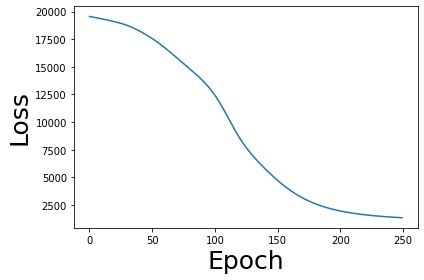

In [22]:
%%time
train_exact_heteroskedastic(model, adam, natgrad, epochs = 250)

In [23]:
model

name,class,transform,prior,trainable,shape,dtype,value
VGP.mean_function.c,Parameter,Identity,,False,"(1, 1)",float64,[[-0.22502439]]
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.3702953120484003
VGP.kernel.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[0.03385951 0.02863558]
VGP.q_mu,Parameter,Identity,,False,"(1156, 1)",float64,[[1.12782579e-06...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 1156, 1156)",float64,"[[[1.64516238e-03, 0.00000000e+00, 0.00000000e+00..."


In [24]:
print(
    f"Training error: {mean_squared_error(Y, model.predict_f(X)[0])}"  # , Testing error: {mean_squared_error(Y_test, model.predict_y(X_test)[0])}"
)

Training error: 0.025339146842422503


In [25]:
bounded_model = BoundedDensityModel(
    likelihood=model.predict_f,
    param_names=param_names,
    priors=prior_ranges,
    parameters_scaler=x_scaler,
    y_scaler=y_scaler,
)

# Evaluate 50% 90% and 99% contour lines for plotting 2D model
* The contour lines are calculated for the GP mean and for the 2-sigma error bands
* To evaluate the contours we evaluate the GP model over a grid of points

In [26]:
Nb = Nb*6
new_bin_array = np.vstack(
    [
        np.linspace(
            unscaled_data["ra"].min() - 0.1, unscaled_data["ra"].max() + 0.1, Nb
        ),
        np.linspace(
            unscaled_data["dec"].min() - 0.1, unscaled_data["dec"].max() + 0.1, Nb
        ),
    ]
)
bin_grid = x_scaler.transform(create_2d_data_set(new_bin_array))

Shape of binning: (209, 2)
Histogram points: (43681, 2)


In [27]:
sigmas = 2 # change here if you want different error bands

In [28]:
# Evaluating the bounded model in "scaled" space
mean, var = bounded_model.predict(bin_grid)
# mean, var = model.predict_f(bin_grid)

In [29]:
bin_shape = Nb - 1

In [30]:
z = y_scaler.inverse_transform(mean)

z_high = y_scaler.inverse_transform(mean + sigmas*np.sqrt(var))
z_high = z_high.reshape(bin_shape, bin_shape)
z_high = z_high / z.sum()

z_low = y_scaler.inverse_transform(mean - sigmas*np.sqrt(var)).clip(min=0.)
z_low = z_low.reshape(bin_shape, bin_shape, order="C")
z_low = z_low / z.sum()

z = z.reshape(bin_shape, bin_shape, order="C")
z = z / z.sum()

n = 1000
t = np.linspace(0, z.max(), n)

integral = ((z >= t[:, None, None]) * z).sum(axis=(1, 2))
f = interpolate.interp1d(integral, t)

t_contours = f(np.array([0.9, 0.5]))

# Marginalise GP model mean and uncertainty over ra and dec

* To propagate the errors from "scaled" space to "real" space we use the uncertainty package
* The marginals are then normalised to be a density: Density counts = N_counts / Volume

In [31]:
mean = mean.reshape(bin_shape, bin_shape, order="C")
gp_var = var.reshape(bin_shape, bin_shape, order="C")

In [32]:
mean_ra = np.mean(mean, axis=1)
mean_dec = np.mean(mean, axis=0)

In [33]:
std_ra = np.sqrt(np.mean(gp_var, axis=1))
std_dec = np.sqrt(np.mean(gp_var, axis=1))

In [34]:
sum_with_error_ra = unumpy.uarray(mean_ra, std_ra)
sum_with_error_dec = unumpy.uarray(mean_dec, std_dec)

In [35]:
scaled_sum_with_error_ra = sum_with_error_ra * y_scaler.scale_
scaled_sum_with_error_ra = scaled_sum_with_error_ra + y_scaler.mean_

scaled_sum_with_error_dec = sum_with_error_dec * y_scaler.scale_
scaled_sum_with_error_dec = scaled_sum_with_error_dec + y_scaler.mean_

In [36]:
# Normalise so that it is a density
scaled_dens_with_error_ra = (
    scaled_sum_with_error_ra
    * 1
    / (unumpy.nominal_values(scaled_sum_with_error_ra) * np.diff(new_bin_array[0])).sum()
)

scaled_dens_with_error_dec = (
    scaled_sum_with_error_dec
    * 1
    / (unumpy.nominal_values(scaled_sum_with_error_dec) * np.diff(new_bin_array[1])).sum()
)

In [37]:
# Extracting error with uncertainty package
scaled_ra_std = unumpy.std_devs(scaled_dens_with_error_ra)
scaled_dec_std = unumpy.std_devs(scaled_dens_with_error_dec)

In [38]:
scaled_ra_mean = unumpy.nominal_values(scaled_dens_with_error_ra)
scaled_dec_mean = unumpy.nominal_values(scaled_dens_with_error_dec)

In [39]:
# Estimating the 2-sigma confidence bands
upper_var_ra = scaled_ra_mean + sigmas * scaled_ra_std
lower_var_ra = scaled_ra_mean - sigmas * scaled_ra_std

upper_var_dec = scaled_dec_mean + sigmas * scaled_dec_std
lower_var_dec = scaled_dec_mean - sigmas * scaled_dec_std

# Combine all plots together

In [40]:
bin_plot = new_bin_array.copy()

In [41]:
counts, bins = np.histogramdd(
    np.array(unscaled_data[param_names]), density=True, bins=new_bin_array
)

In [42]:
summary_ra = calc_mean_and_ci(unscaled_data["ra"])
summary_dec = calc_mean_and_ci(unscaled_data["dec"])
print(r"PE ra = {}".format(summary_ra.string))
print(r"PE dec = {}".format(summary_dec.string))

PE ra = ${1.62}_{-0.57}^{+0.74}$
PE dec = ${-1.20}_{-0.06}^{+0.13}$


In [43]:
from scipy.interpolate import interp1d

### do inverse empirical cdfs to get credible intervals from GP

In [44]:
f_dec = interp1d(np.cumsum(scaled_dec_mean,)/np.cumsum(scaled_dec_mean,)[-1],centroid_calc(bins[1]))
f_ra = interp1d(np.cumsum(scaled_ra_mean,)/np.cumsum(scaled_ra_mean,)[-1],centroid_calc(bins[0]))

## Make Plot

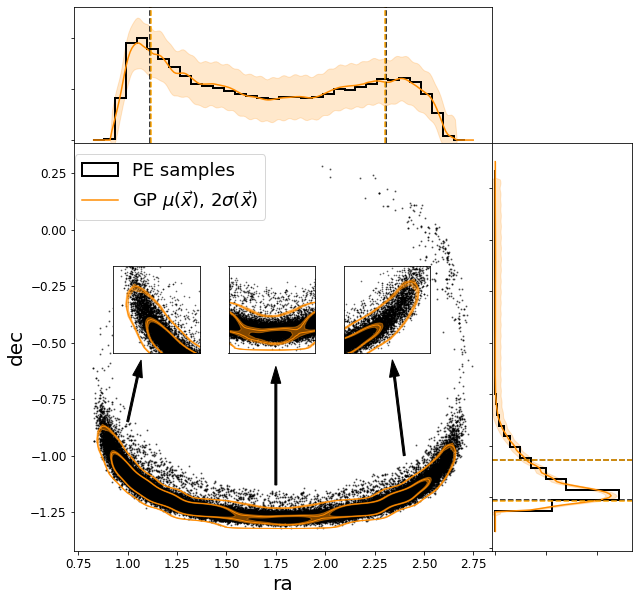

In [45]:
%matplotlib inline
fig, axes = plt.subplots(
    figsize=(10, 10),
    sharex=False,
    sharey=False,
    ncols=2,
    nrows=2,
    gridspec_kw={"width_ratios": [3, 1], "height_ratios": [1, 3]},
)

plot_1d_histograms_with_GP(axes,
                           unscaled_data,
                           bins,
                           scaled_ra_mean,
                           scaled_dec_mean,
                           lower_var_ra,
                           upper_var_ra,
                           lower_var_dec,
                           upper_var_dec)

plot_1d_credible_intervals(axes, f_ra, f_dec, summary_ra, summary_dec)

lower_contours, upper_contours = get_contour_bounds(axes, t_contours, z_low, z_high)
xx_lower, xx_upper, yy_lower, yy_upper, interp_lower_x, interp_lower_y, interp_upper_x, interp_upper_y = get_fill_positions(lower_contours, upper_contours)

make_central_fill_plot(xx_lower,
                       xx_upper,
                       yy_lower,
                       yy_upper,
                       interp_lower_x,
                       interp_lower_y,
                       interp_upper_x,
                       interp_upper_y)

make_zoom_insets(unscaled_data,
                     xx_lower,
                     interp_lower_x,
                     yy_lower,
                     interp_lower_y,
                     xx_upper,
                     interp_upper_x,
                     yy_upper,
                     interp_upper_y, 
                     new_bin_array
                    )

plot_arrows(axes)

do_plot_formatting()

add_legend_to_plot(axes)

# plt.savefig("GP_2D_sky_loc.png", dpi=100)

### Compare GP uncertainty with bootstrap

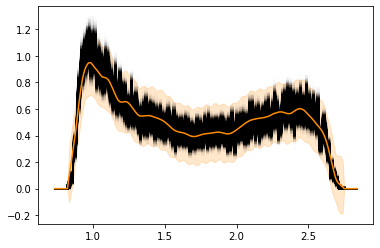

In [46]:
for i in range(6000):
    ra_boot = np.random.choice(unscaled_data["ra"], int(len(unscaled_data["ra"])/2))
    plt.hist(
    ra_boot,
    density=True,
    histtype="step",
    bins=bin_plot[0],
    linewidth=2,
    alpha = 0.01,
    label="PE samples",
    color='k',)

plt.plot(
    centroid_calc(bins[0]),
    scaled_ra_mean,
    color='darkorange',
    label=r"GP $\mu(\vec{x})$, $2\sigma(\vec{x})$",
)

plt.fill_between(
    centroid_calc(bins[0]),
    upper_var_ra,
    lower_var_ra,
    color='darkorange',
    alpha=0.2,
)

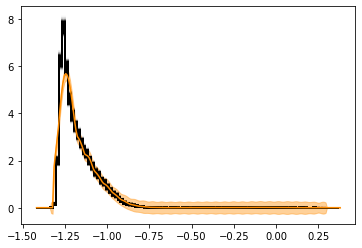

In [47]:
for i in range(6000):
    dec_boot = np.random.choice(unscaled_data["dec"], int(len(unscaled_data["dec"])/2))
    
    plt.hist(
    dec_boot,
    density=True,
    histtype="step",
    bins=bin_plot[1][::2],
    linewidth=2,
        alpha = 0.01,
    label="PE samples",
    color='k',)

plt.plot(
    centroid_calc(bins[1]),
    scaled_dec_mean,
    color='darkorange',
    label=r"GP $\mu(\vec{x})$, $2\sigma(\vec{x})$",
)

plt.fill_between(
    centroid_calc(bins[1]),
    upper_var_dec,
    lower_var_dec,
    color='darkorange',
    alpha=0.4,
)

## Extra: re-sample ra and dec with MCMC

In [48]:
# %%time
# mcmc_points = 5000
# num_burnin = mcmc_points * 0.5
# num_chains = 10

# print(f"mcmc_points: {mcmc_points}, num_burnin: {int(num_burnin)}")
# print("Running chain..")
# all_samples = bounded_model.sample_density(
#     num_results=mcmc_points,
#     num_burnin_steps=int(num_burnin),
#     initialise_chains=x_scaler.transform(np.array([1.0, -1.168]).reshape(1, -1))
#     + 1e-6 * np.random.randn(num_chains, X.shape[1]),
#     sampler="MCMC",
# )

In [49]:
# dim = len(param_names)

In [50]:
# combine_chains = np.zeros((mcmc_points * num_chains, dim))
# for i in range(dim):
#     combine_chains[:, i] = all_samples[:, :, i].numpy().flatten()
# gp_samples = x_scaler.inverse_transform(combine_chains)

# az_data = convert_to_arviz_data(all_samples, x_scaler, param_names)

# az.summary(az_data)

In [51]:
# %matplotlib inline
# fig1 = corner.corner(
#     unscaled_data[param_names],
#     bins=50,
#     plot_datapoints=False,
#     labels=param_names,
#     color="k",
#     smooth=0.9,
#     levels=[
#         0.5,
#         0.9,
#     ],
#     hist_kwargs={"density": True},
#     quantiles=[0.05, 0.95],
# )

# fig = corner.corner(
#     gp_samples,
#     fig=fig1,
#     bins=50,
#     plot_datapoints=False,
#     labels=param_names,
#     color="darkorange",
#     smooth=0.9,
#     levels=[
#         0.5,
#         0.9,
#     ],
#     hist_kwargs={"density": True},
#     quantiles=[0.05, 0.95],
# )

# for ax in fig.get_axes():
#     ax.tick_params(axis="both", labelsize=14)

In [52]:
# summary_ra = calc_mean_and_ci(unscaled_data["ra"])
# summary_dec = calc_mean_and_ci(unscaled_data["dec"])
# print(r"PE ra = {}".format(summary_ra.string))
# print(r"PE dec = {}".format(summary_dec.string))

In [53]:
# summary_ra = calc_mean_and_ci(gp_samples[:,0])
# summary_dec = calc_mean_and_ci(gp_samples[:,1])
# print(r"GP ra = {}".format(summary_ra.string))
# print(r"GP dec = {}".format(summary_dec.string))